<a href="https://colab.research.google.com/github/Salesjdsj/Data_science/blob/main/Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Detecção de Fraudes em Cartões de Crédito

Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.

<p align=center>
<img src="https://www.dropbox.com/s/ni9pz2u15ibf5dz/photo-1620714223084-8fcacc6dfd8d.jpeg?dl=1" width="60%"></p>

Dentre essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acarretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente, o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3, \dots, V28]$. 

<p align=center>
<img src="https://www.dropbox.com/s/lwsacmxyf8kd8bq/photo-1592772874383-d08932d29db7.jpeg?dl=1" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor ou igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3, \dots, V28]$.

In [86]:
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

!pip install -q scikit-plot

In [87]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scikitplot as skplt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from IPython.display import Image  
import pydotplus


In [88]:
# Configurar o notebook
sns.set_style('white')

# configurar a fonte
plt.rcParams['font.family'] = 'Arial'

# configurar as cores que usarei no plot
AZUL = "#003F5c" 
CINZA = "#9E9E9E"
CINZA_TEXTO = "#515151"

Para facilitar a aquisição dos dados, criei um *link* com acesso direto ao `csv`. Com isso, basta importar o conjunto de dados usando o método `pd.read_csv()`.

In [89]:
file_path = "https://www.dropbox.com/s/3w5z9buastnhcew/creditcard.csv?dl=1"

# importar os dados para um dataframe
df = pd.read_csv(file_path)

Com os dados importados para dentro de uma estrutura *Dataframe* - e não havendo a necessidade de mais nenhum ajuste ou configuração nesta etapa, pode-se iniciar uma análise exploratória dos dados a fim de preparar um modelo de *Machine Learning*.

## **Análise Exploratória**


### **Vamos analisar as 5 primeiras entradas do dataframe:**

In [90]:
# ver as primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### **Q1. Quantas *features* e quantas entradas o nosso conjunto de dados possui? Quais os tipos das variáveis?**

Nota-se que o *dataframe* é composto por 284.807 entradas e 31 features. Todas são do tipo float exceto a variável `Class`que é do tipo inteiro.



In [91]:
# identificar o volume de dados do DataFrame
print("Entradas:\t {}".format(df.shape[0]))
print("Features:\t {}\n".format(df.shape[1]))

# verificar o tipo das variáveis do dataset
display(df.dtypes)

Entradas:	 284807
Features:	 31



Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

### **Q2. Qual é o resumo estatístico da feature Class?**

Vamos utilizar o método `describe`para visualizar o resumo estatístico do conjunto de dados.

Pela análise dos dados abaixo, observa-se o seguinte:
* O valor **mean** da feature `Class`corresponde a 0.1727% (operações fraudulentas);
* O dataset é composto por 284.807 transações.

In [92]:
# ver o resumo estatístico
df['Class'].describe()

count    284807.000000
mean          0.001727
std           0.041527
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Class, dtype: float64

### **Q3. Qual a porcentagem de valores ausentes no *dataset*?**

A qualidade de um *dataframe* está diretamente relacionada à quantidade de valores ausentes. É importante entender logo no início se esses valores nulos são significativos comparados ao total de entradas.

* Após análise do *dataframe* observamos a inexistência de valores ausentes, assim não se faz necessário um trabalho de limpeza.

In [93]:
# ordenar em ordem decrescente as variáveis por seus valores ausentes
(df.isnull().sum() / df.shape[0]).sort_values()

Time      0.0
V28       0.0
V27       0.0
V26       0.0
V25       0.0
V24       0.0
V23       0.0
V22       0.0
V21       0.0
V20       0.0
V19       0.0
V18       0.0
V17       0.0
V16       0.0
Amount    0.0
V15       0.0
V13       0.0
V12       0.0
V11       0.0
V10       0.0
V9        0.0
V8        0.0
V7        0.0
V6        0.0
V5        0.0
V4        0.0
V3        0.0
V2        0.0
V1        0.0
V14       0.0
Class     0.0
dtype: float64

### **Q4. Como está o balanceamento do dataset?**

Analisando o dataset, podemos notar que:
* a **classe 0** representa as **operações lícitas**, totalizando 284.315 transações; e
* a **classe 1** representa as **operações fraudulentas**, totalizando 492 transações.

Como as operações ilícitas representam apenas 0,17% do total, mal é possível visualizar a barra representativa.

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.1727% do dataset.



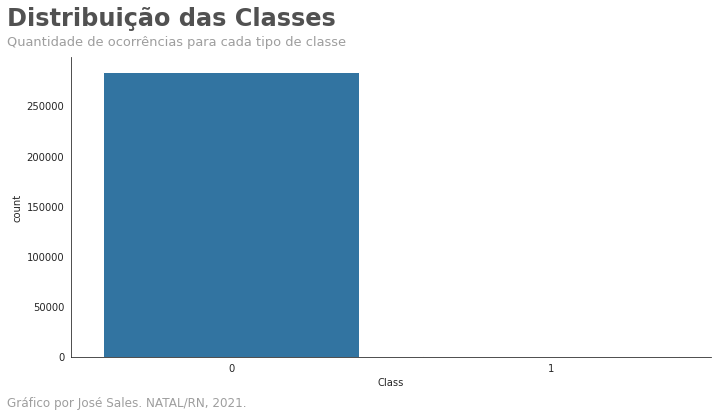

In [94]:
# Checar o balanceamento das classes
print(df.Class.value_counts())
print('\nFraudes representam {:.4f}% do dataset.\n'.format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

# Plotar gráfico de barras para as Classes
# Definindo a figura
fig , ax = plt.subplots(figsize=(10,6), dpi=72)

# Plot do gráfico
sns.countplot('Class', data=df,ax=ax);

# title
ax.text(-0.7, 330000,'Distribuição das Classes', fontsize=24, color=CINZA_TEXTO, fontweight='bold')
ax.text(-0.7, 310000,'Quantidade de ocorrências para cada tipo de classe', fontsize=13, color=CINZA)

# remover spines da direita e superior
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# rodapé
ax.text(
    -0.7,
    -50000,
    "Gráfico por José Sales. NATAL/RN, 2021.",
    fontsize=12, color=CINZA
    )


plt.tight_layout();

### **Q5. Qual o tipo de distribuição das variáveis?** 

Para identificar a distribuição das variáveis, irei plotar o histograma para as variáveis `Time`e `Amount`.

Através da análise dos gráficos e do Boxplot abaixo, podemos notar que:

* A maioria das transações legítimas são de valores inferiores a $250.00, sendo também o maior montante das transações fraudulentas.

* 84.95% (418) transações fraudulentas tem o valor abaixo de $250.00.

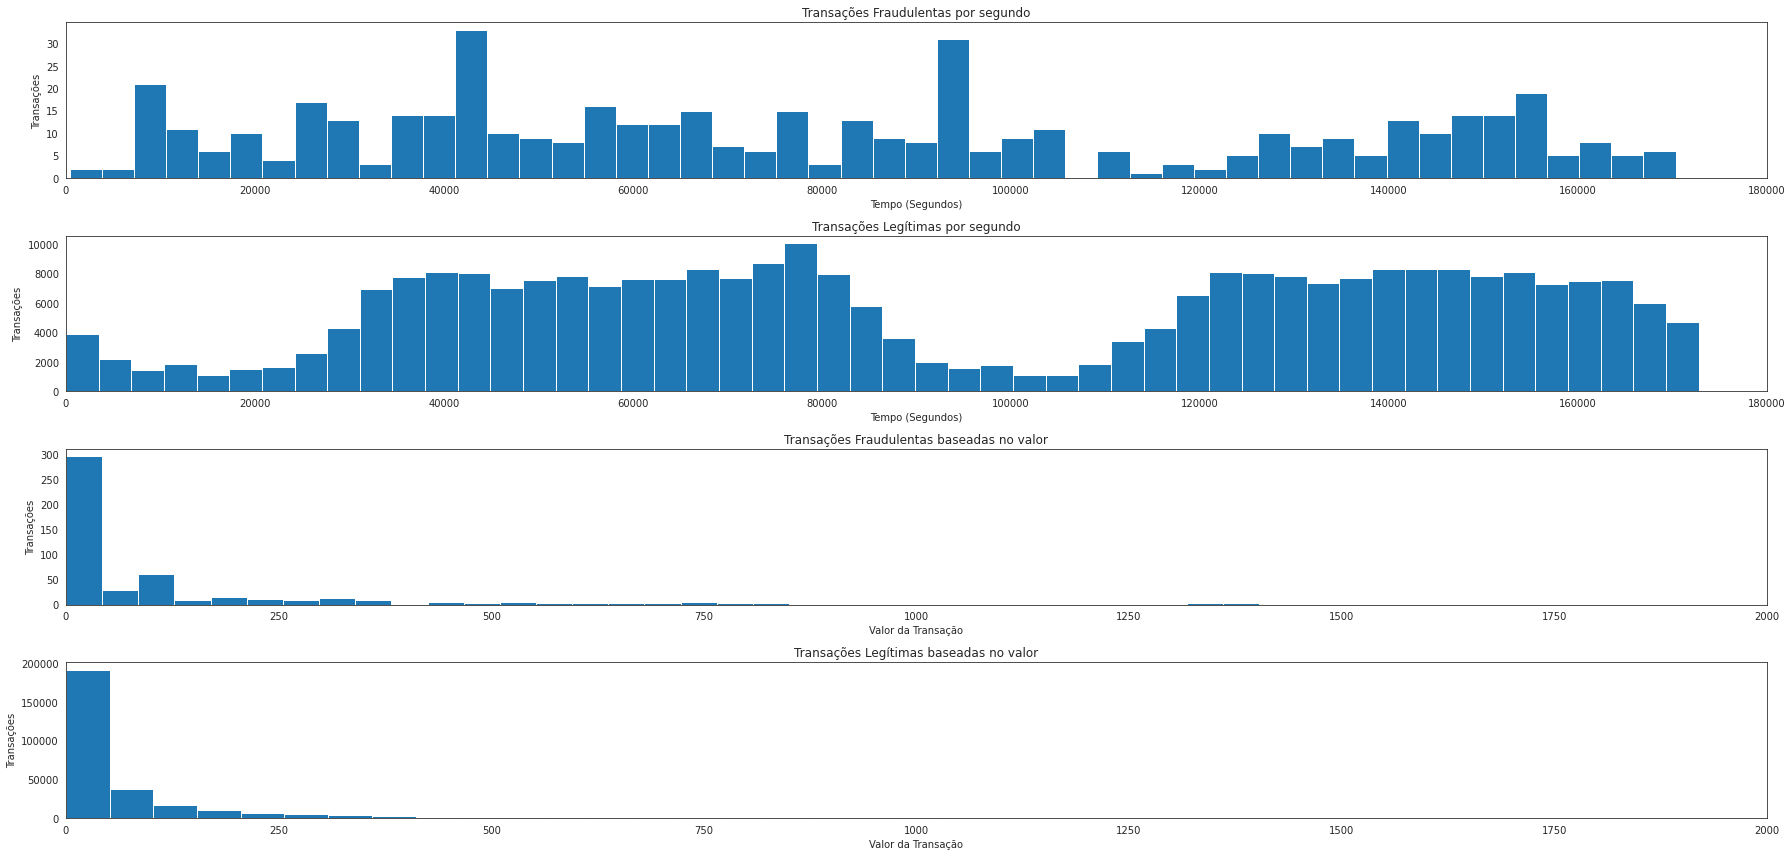

In [143]:
# Plotar gráfico 
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(25,12), dpi=72)

# Definir número de barras dos gráficos
num_bins_time = 50
num_bins_amount = 50

# Gráfico 1
ax[0].hist(df.Time[df.Class == 1], bins = num_bins_time)
ax[0].set_title('Transações Fraudulentas por segundo')
ax[0].set_ylabel('Transações')
ax[0].set_xlabel('Tempo (Segundos)')
ax[0].set_xlim(0,180000)

# Gráfico 2
ax[1].hist(df.Time[df.Class == 0], bins = num_bins_time)
ax[1].set_title('Transações Legítimas por segundo')
ax[1].set_ylabel('Transações')
ax[1].set_xlabel('Tempo (Segundos)')
ax[1].set_xlim(0,180000)

# Gráfico 3
ax[2].hist(df.Amount[df.Class == 1], bins = num_bins_amount)
ax[2].set_title('Transações Fraudulentas baseadas no valor')
ax[2].set_ylabel('Transações')
ax[2].set_xlabel('Valor da Transação')
ax[2].set_xlim(0,2000)


# Gráfico 4
ax[3].hist(df.Amount[df.Class == 0], bins = 500)
ax[3].set_title('Transações Legítimas baseadas no valor')
ax[3].set_ylabel('Transações')
ax[3].set_xlabel('Valor da Transação')
ax[3].set_xlim(0,2000)

# Mostrar gráficos
plt.tight_layout();

Vamos plotar um boxplot para a variável `Amount` para o casos em que houveram fraudes (`Class == 1`).

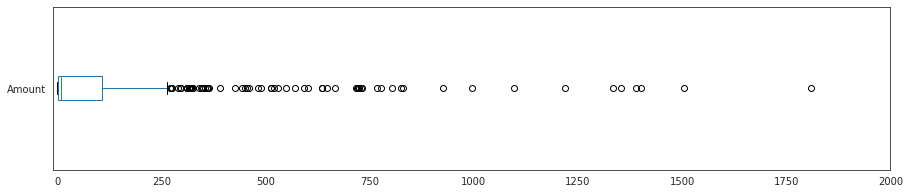


Amount: valores abaixo de $250.00:
418 entradas
84.9593%


In [96]:
# Criando uma cópia do Dataframe
df_class1 = df.copy()

# Excluindo as linhas com as operações legítimas (Class == 0)
df_class1.drop(df_class1[df_class1.Class == 0].index, axis=0, inplace=True)

# Plotando o Boxplot para a variável Amount
df_class1.Amount.plot(kind='box', vert=False, figsize=(15, 3), xlim=(-10,2000))

# Mostrar o Boxplot
plt.show()

# ver quantidade de valores abaixo de 250 para Amount
print("\nAmount: valores abaixo de $250.00:")
print("{} entradas".format(len(df_class1[df_class1.Amount < 250])))
print("{:.4f}%".format((len(df_class1[df_class1.Amount < 250]) / df_class1.shape[0])*100))



### **Q6. Qual a correlação existente entre as variáveis?**

Correlação significa que existe uma relação entre duas coisas. No nosso contexto, estamos buscando relação ou semelhança entre duas variáveis.

Essa relação pode ser medida, e é função do coeficiente de correlação estabelecer qual a intensidade dela. Para identificar as correlações existentes entre as variáveis de interesse, vamos:

* Criar uma matriz de correlação; e
* Gerar um *heatmap* a partir dessa matriz, usando a biblioteca *seaborn*.

In [97]:
# criar uma matriz de correlação
corr = df.corr()

# mostrar a matriz de correlação
display(corr)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,3.061663e-02,-2.476894e-01,1.243481e-01,-6.590202e-02,-9.875682e-02,-1.834533e-01,1.190287e-02,-7.329721e-02,9.043813e-02,2.897530e-02,-5.086602e-02,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.697350e-17,-1.424390e-15,1.755316e-17,6.391162e-17,2.398071e-16,1.991550e-15,-9.490675e-17,2.169581e-16,7.433820e-17,2.438580e-16,2.422086e-16,-2.115458e-16,9.352582e-16,-3.252451e-16,6.308789e-16,-5.011524e-16,2.870125e-16,1.818128e-16,1.036959e-16,-1.755072e-16,7.477367e-17,9.808705e-16,7.354269e-17,-9.805358e-16,-8.621897e-17,3.208233e-17,9.820892e-16,-0.227709,-0.101347
V2,-0.010593,4.697350e-17,1.000000e+00,2.512175e-16,-1.126388e-16,-2.039868e-16,5.024680e-16,3.966486e-16,-4.413984e-17,-5.728718e-17,-4.782388e-16,9.468995e-16,-6.588252e-16,3.854521e-16,-2.541036e-16,2.831060e-16,4.934097e-17,-9.883008e-16,2.636654e-16,9.528280e-17,-9.309954e-16,8.444409e-17,2.500830e-16,1.059562e-16,-8.142354e-18,-4.261894e-17,2.601622e-16,-4.478472e-16,-3.676415e-16,-0.531409,0.091289
V3,-0.419618,-1.424390e-15,2.512175e-16,1.000000e+00,-3.416910e-16,-1.436514e-15,1.431581e-15,2.168574e-15,3.433113e-16,-4.233770e-16,6.289267e-16,-5.501758e-17,2.206522e-16,-6.883375e-16,4.271336e-16,1.122756e-16,1.183364e-15,4.576619e-17,5.427965e-16,2.576773e-16,-9.429297e-16,-2.971969e-17,4.648259e-16,2.115206e-17,-9.351637e-17,4.771164e-16,6.521501e-16,6.239832e-16,7.726948e-16,-0.210880,-0.192961
V4,-0.105260,1.755316e-17,-1.126388e-16,-3.416910e-16,1.000000e+00,-1.940929e-15,-2.712659e-16,1.556330e-16,5.195643e-16,3.859585e-16,6.055490e-16,-2.083600e-16,-5.657963e-16,-1.506129e-16,-8.522435e-17,-1.507718e-16,-6.939204e-16,-4.397925e-16,1.493667e-16,-2.656938e-16,-3.223123e-16,-9.976950e-17,2.099922e-16,6.002528e-17,2.229738e-16,5.394585e-16,-6.179751e-16,-6.403423e-17,-5.863664e-17,0.098732,0.133447
V5,0.173072,6.391162e-17,-2.039868e-16,-1.436514e-15,-1.940929e-15,1.000000e+00,7.926364e-16,-4.209851e-16,7.589187e-16,4.205206e-16,-6.601716e-16,7.342759e-16,3.761033e-16,-9.578659e-16,-3.634803e-16,-5.132620e-16,-3.517076e-16,1.425729e-16,1.109525e-15,-3.138234e-16,2.076048e-16,-1.368701e-16,5.060029e-16,1.637596e-16,-9.286095e-16,5.625102e-16,9.144690e-16,4.465960e-16,-3.299167e-16,-0.386356,-0.094974
V6,-0.063016,2.398071e-16,5.024680e-16,1.431581e-15,-2.712659e-16,7.926364e-16,1.000000e+00,1.429426e-16,-1.707421e-16,1.114447e-16,2.850776e-16,4.865799e-16,2.140589e-16,-2.268061e-16,3.452801e-16,-6.368111e-18,-2.477917e-16,3.567582e-16,2.811474e-16,2.717167e-16,1.898638e-16,-1.575903e-16,-3.362902e-16,-7.232186e-17,-1.261867e-15,1.081933e-15,-2.378414e-16,-2.623818e-16,4.813155e-16,0.215981,-0.043643
V7,0.084714,1.991550e-15,3.966486e-16,2.168574e-15,1.556330e-16,-4.209851e-16,1.429426e-16,1.000000e+00,-8.691834e-17,7.933251e-16,3.043333e-17,-1.084105e-15,1.510045e-15,-9.892325e-17,-1.729462e-16,1.936832e-17,2.893672e-16,1.149692e-15,-1.116789e-16,-2.874017e-16,1.744242e-16,1.938604e-16,-1.058131e-15,2.327911e-16,-2.589727e-17,1.174169e-15,-7.334507e-16,-5.886825e-16,-6.836764e-17,0.397311,-0.187257
V8,-0.036949,-9.490675e-17,-4.413984e-17,3.433113e-16,5.195643e-16,7.589187e-16,-1.707421e-16,-8.691834e-17,1.000000e+00,2.900829e-16,9.051847e-17,1.954747e-16,-6.266057e-17,-2.382948e-16,-1.131098e-16,2.021491e-16,5.027192e-16,-3.508777e-16,-4.093852e-16,-5.339821e-16,-1.095534e-16,-2.412439e-16,5.475559e-16,3.897104e-16,-1.802967e-16,-1.390791e-16,-1.209975e-16,1.733633e-16,-4.484325e-16,-0.103079,0.019875
V9,-0.008660,2.169581e-16,-5.728718e-17,-4.233770e-16,3.859585e-16,4.205206e-16,1.114447e-16,7.933251e-16,2.900829e-16,1.000000e+00,-2.771761e-16,4.682341e-16,-2.445230e-15,-2.650351e-16,2.343317e-

In [98]:
# criando uma máscara para plotar somente uma parte da matriz

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

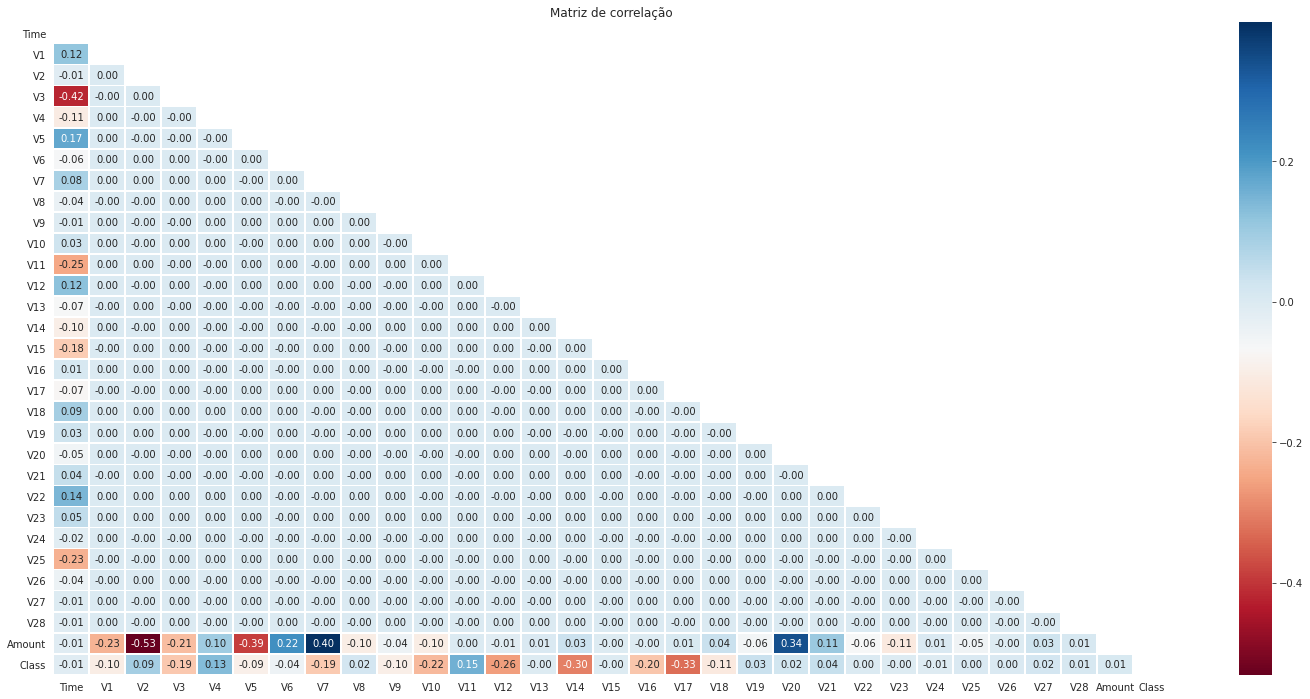

In [99]:
# plotar um heatmap a partir das correlações
f, ax = plt.subplots(figsize=(25, 12), dpi = 72)
sns.heatmap(corr, mask=mask, cmap='RdBu', fmt='.2f', linecolor='white', annot=True, linewidths=.7);

# title
plt.title('Matriz de correlação');

## **Preparação dos Dados**
Nesta etapa vamos:
  * Normalizar os dados que ainda não haviam sido pré-processados (`Time` e `Amount`);
  * Dividir o conjunto de dados entre treino e validação; e
  * Balancear o conjunto de dados.


###**Padronizar `Time` e `Amount`**

Nessa etapa, iremos normalizar os dados da coluna `Time` e `Amount`, que possuíam seus valores originais. Para isso, a padronização será feita por meio da classe `StandardScaler`.

In [100]:
# Criar cópia do DataFrame 
df_clean = df.copy()

# Padronizar as colunas Time e Amount
scaler = StandardScaler()
df_clean['Scaler_amount'] = scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['Scaler_time'] = scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

# Excluir as colunas Time e Amount
df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# Ver as primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Scaler_amount,Scaler_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


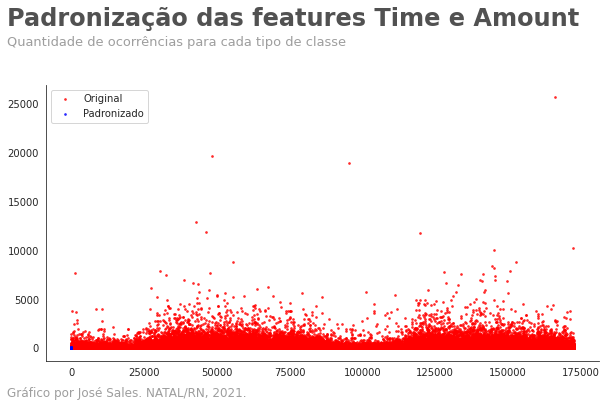

In [113]:
# Plotar o gráfico para vizualizar
fig, ax = plt.subplots(figsize=(9, 6), dpi = 72)
ax.scatter('Time', 'Amount', c='red', s=3, label='Original', alpha=.7, data=df)
ax.scatter('Scaler_time', 'Scaler_amount', c='blue', s=3, label='Padronizado', alpha=.7, data=df_clean)

# title
ax.text(-22000, 33000,'Padronização das features Time e Amount', fontsize=24, color=CINZA_TEXTO, fontweight='bold')
ax.text(-22000, 31000,'Quantidade de ocorrências para cada tipo de classe', fontsize=13, color=CINZA)

# remover spines da direita e superior
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# rodapé
ax.text(
    -22000,
    -5000,
    "Gráfico por José Sales. NATAL/RN, 2021.",
    fontsize=12, color=CINZA
    )

# Inserir legenda
plt.legend(loc='upper left')


plt.tight_layout();


###**Separar dados entre Treino e Teste**

Iremos também dividir o conjunto de dados entre treino e teste, assim poderemos testar o modelo com uma base de dados que ele não teve contato.

As features estão na variável X e na variável y temos o nosso target (o que queremos prever).

In [114]:
# separar variáveis entre X e y
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

# Dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True )

print('O dataset de treino possui {} transações e o de teste {}.'.format(X_train.shape[0], X_test.shape[0]))

O dataset de treino possui 213605 transações e o de teste 71202.


Observe que não passamos o test_size, então por padrão os dados serão separados em 75-25 (75% para treinamento e 25% para teste). Essa divisão fica a seu critério.

###**Balanceamento dos dados**

Por fim, iremos balancear os dados, de forma que nossos modelos apresentem um melhor desempenho na hora de identificar transações fraudulentas.

Alguns exemplos de situações onde o desbalanceamento é quase certo são problemas de detecção de fraude e diagnóstico médicos. É intuitivo pensar que existem mais transações lícitas que criminosas, ou que o conjunto de pessoas diagnosticadas com câncer é bem menor que o conjunto de pessoas sem a doença.

**Consequências dos dados desbalanceados**

Se você está construindo um modelo de *machine learning* para classificação, por exemplo, a consequência desse desequilíbrio é que o modelo terá uma tendência a dar muitos "alarmes falsos".

Ou seja, na prática ele irá responder muito bem entradas para as classes majoritárias, mas terá um desempenho inferior para as minoritárias.

No exemplo de detecção de fraude com cartões de crédito (onde o número de transações financeiras normais é bem maior que o número de transações fraudulentas), um classificador tenderá a apresentar muitos falsos negativos - uma situação indesejável para um banco, obviamente.

Em um *trade-off*, seria preferível "errar para mais" e ter uma quantidade maior de falsos positivos. Aliás, aposto que você já teve seu cartão bloqueado preventivamente e teve que ligar no banco para confirmar as últimas compras que havia feito, não é mesmo?!

Teoricamente, um *dataset* que possua qualquer classe com mais de 50% das entradas já é considerado desbalanceado. No entanto, há situações extremas onde você vai encontrar proporções maiores que 99:1.

Existem várias maneiras para lidar com dados desbalanceados, cada uma com seus prós e contras, no entanto, nesse estudo iremos utilizar a abordagem ***sampling*** .

***Sampling***

*Sampling* é um pré-processamento que visa minimizar as discrepâncias entre as classes por meio de um rearranjo do *dataset* original. Para gerar um conjunto balanceado, são usadas normalmente as seguintes técnicas: ***Over-sampling*** e  ***Under-sampling.***

---
<img alt="Colaboratory logo" width="80%" src="https://www.
dropbox.com/s/ei4uccplv8wip4s/1_-9Y4VyZm7OqBYAdKEmAb6w.png?dl=1">

---
Como mostra a figura acima, basicamente são métodos que equalizam a quantidade das classificações desbalanceadas. Em outras palavras, ou ele irá diminuir o conjunto de observações com a classificação majoritária, ou irá aumentar as observações com a classificação minoritária.

####**Balanceamento dos dados utilizando a técnica Under-sampling**

1    369
0    369
dtype: int64


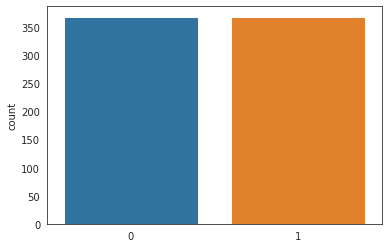

In [115]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_rus);

O novo conjunto está corretamente balanceado, eliminando boa parte do problema que tínhamos inicialmente. Observamos que ambas as classes (0 ou 1), possuem 369 entradas, ou seja, houve uma redução da classe = 0.


####**Balanceamento dos dados utilizando a técnica Over-sampling**

1    213236
0    213236
dtype: int64


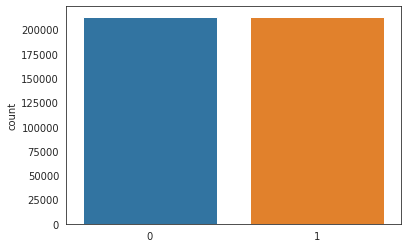

In [116]:
# usar técnica over-sampling
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_ros).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_ros);

O novo conjunto está corretamente balanceado, eliminando boa parte do problema que tínhamos inicialmente. Observamos que ambas as classes (0 ou 1), possuem 213.236 entradas, ou seja, houve um aumento da classe = 1.

## **Modelos de Machine Learning**

Nessa etapa vamos contruir dois modelos de Machine Learning, utilizando duas técnicas distintas de balanceamento de dados e escolher o mais adequado para a detecção de fraudes em cartões de crédito. Os modelos serão:

*   Regressão Logística; e

*   Árvore de decisão.



### **Regressão Logística com os dados desbalanceados**
A regressão logística serve para classificar algo dentro de um conjunto de categorias, dessa maneira, é ideal para dividir as operações entre lícitas ou fraudulentas.

Vamos agora instanciar um modelo de Regressão Logística e treiná-lo nesses dados desbalanceados. 

In [117]:
# Escolher e instanciar os Hyperparameters
model_log = LogisticRegression()

# Fit do Modelo (Treinar)
model_log.fit(X_train, y_train)

# fazer as previsões em cima dos dados de teste
y_pred_log = model_log.predict(X_test)

#### **Avaliar o desempenho do modelo**

Antes de olhar as métricas de avaliação do modelo, vamos relembrar os conceitos:

---
<img alt="Colaboratory logo" width="60%" src="https://www.dropbox.com/s/jid4hhir2ryt60b/1_OhEnS-T54Cz0YSTl_c3Dwg.jpeg?dl=1">

---

* **Verdadeiro positivo (*true positive* — TP):** Por exemplo, quando transação é fraudulenta e o modelo classifica fraudulenta.

* **Falso positivo (*false positive* — FP):** Por exemplo, quando a transação é lícita e o modelo classifica como fraudulenta.

* **Verdadeiro negativo (*true negative* — TN):** Por exemplo, quando a transação é lícita e o modelo classifica como lícita.

* **Falso negativo (*false negative* — FN):** Por exemplo, quando a transação é fraudulenta e o modelo classifica como lícita.


##### **Matriz de confusão**

A matriz de confusão nos mostra o número exato de registros classificados por classe.
Assim, obtemos os seguintes resultados:
* Para as **transações lícitas**:
  * 100% foram classificadas corretamente (verdadeiro negativo);
  * 0% foram classificadas como fraudulentas (falso positivo);
* Para as **transações fraudulentas**:
  * 37% foram classificadas como lícitas (falso negativo);
  * 63% foram classificadas como fraudulentas (verdadeiro positivo);

Os falsos negativos representam prejuízo para os bancos que terão que arcar com os danos causados ao seu patrimônio. Já os falsos positivos ocorrem nas ocasiões em que um cidadão comum tenta fazer a compra de algum produto e tem o seu cartão bloqueado "preventivamente". Assim, ambas as situações devem ser evitadas, porém o nosso maior objetivo deve ser a diminuição do percentual de transações fraudulentas classificadas como lícitas.

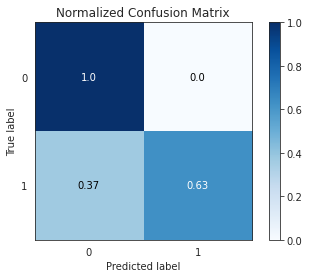

In [118]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_log, normalize=True);

##### **Relatório de Classificação**

**Entendendo o Relatório de Classificação:**

* **precision**: é a capacidade do classificador de não rotular como positiva uma amostra negativa. No caso desse estudo, não classificar como fraudulenta uma transação lícita.
* **recall**: é a capacidade do classificador de encontrar todas as amostras positivas. Ou seja, identificar todas as operações ilícitas.
* **f1-score**: pode ser interpretada como uma média harmônica ponderada de precisão e recall, onde uma pontuação F-beta atinge seu melhor valor em 1 e a pior pontuação em 0. Os pesos da pontuação F-beta lembram mais do que a precisão por um fator de beta. beta = 1.0 significa que o recall e a precisão são igualmente importantes.
* **support**: é o número de ocorrências de cada classe.

A **acurácia** informa em geral quanto um modelo está acertando.

**AUC:**
O valor do AUC varia de 0,0 até 1,0 e o limiar entre a classe é 0,5. Ou seja, acima desse limite, o algoritmo classifica em uma classe e abaixo na outra classe.
Quanto maior o AUC, melhor. Portanto, um modelo cujas previsões estão 100% erradas tem uma AUC de 0, enquanto um modelo cujas previsões são 100% corretas tem uma AUC de 1.

Assim, pela análise da imagem abaixo, observa-se que o modelo 2 é melhor que o modelo 1, pois indica uma maior quantidade de verdadeiros positivos e menor quantidade de falsos positivos.

---
<img alt="Colaboratory logo" width="60%" src="https://www.dropbox.com/s/pkutyjsz8c12o1i/1_HgMhMbeyYdBBiyWI3PPdDQ.png?dl=1">

---



**Analisando o Relatório de classificação:**

Para o enfoque do nosso estudo, serão os considerados os valores de recall e AUC para se estabelecer uma comparação entre os modelos.

*   Recall: 62,60% é  capacidade desse modelo identificar todas as operações ilícitas;
*   AUC: 0.8129.




In [119]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_log, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_log)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_log)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     71079
           1     0.8750    0.6260    0.7299       123

    accuracy                         0.9992     71202
   macro avg     0.9372    0.8129    0.8647     71202
weighted avg     0.9991    0.9992    0.9991     71202

Acurácia: 0.9992

AUC: 0.8129



### **Regressão Logística com os dados balanceados pelo método Under-sampling**
Vamos agora instanciar um modelo de Regressão Logística e treiná-lo nesses dados balanceados.

In [120]:
# Escolher e instanciar os Hyperparameters
model_rus = LogisticRegression()

# Fit do Modelo (Treinar)
model_rus.fit(X_rus, y_rus)

# fazer as previsões em cima dos dados de teste
y_pred_rus = model_rus.predict(X_test)

#### **Avaliar o desempenho do modelo**


##### **Matriz de confusão**

Obtemos os seguintes resultados:

* Para as **transações lícitas**:
  * 97% foram classificadas corretamente (verdadeiro negativo);
  * 3% foram classificadas como fraudulentas (falso positivo);
* Para as **transações fraudulentas**:
  * 11% foram classificadas como lícitas (falso negativo);
  * 89% foram classificadas como fraudulentas (verdadeiro positivo);


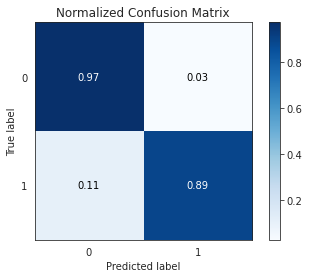

In [121]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rus, normalize=True);

##### **Relatório de Classificação**


**Analisando o Relatório de classificação:**

*   Recall: 89,43% é  capacidade desse modelo identificar todas as operações ilícitas;
*   AUC: 0.9323.


In [122]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_rus, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_rus)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_rus)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9702    0.9848     71079
           1     0.0494    0.8943    0.0937       123

    accuracy                         0.9701     71202
   macro avg     0.5246    0.9323    0.5392     71202
weighted avg     0.9982    0.9701    0.9833     71202

Acurácia: 0.9701

AUC: 0.9323



### **Regressão Logística com os dados balanceados pelo método Over-sampling**
Vamos agora instanciar um modelo de Regressão Logística e treiná-lo nesses dados balanceados.

In [123]:
# Escolher e instanciar os Hyperparameters
model_ros = LogisticRegression()

# Fit do Modelo (Treinar)
model_ros.fit(X_ros, y_ros)

# fazer as previsões em cima dos dados de teste
y_pred_ros = model_ros.predict(X_test)

#### **Avaliar o desempenho do modelo**

##### **Matriz de confusão**

Obtemos os seguintes resultados:

* Para as **transações lícitas**:
  * 98% foram classificadas corretamente (verdadeiro negativo);
  * 2% foram classificadas como fraudulentas (falso positivo);
* Para as **transações fraudulentas**:
  * 10% foram classificadas como lícitas (falso negativo);
  * 90% foram classificadas como fraudulentas (verdadeiro positivo);

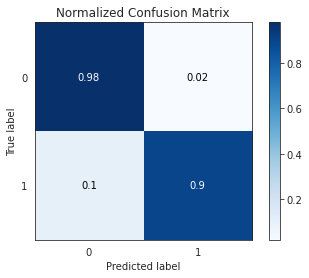

In [124]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_ros, normalize=True);

##### **Relatório de Classificação**

**Analisando o Relatório de classificação:**

*   Recall: 90,24% é  capacidade desse modelo identificar todas as operações ilícitas;
*   AUC: 0.9408.

In [125]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_ros, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_ros)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_ros)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9791    0.9893     71079
           1     0.0694    0.9024    0.1289       123

    accuracy                         0.9789     71202
   macro avg     0.5346    0.9408    0.5591     71202
weighted avg     0.9982    0.9789    0.9879     71202

Acurácia: 0.9789

AUC: 0.9408



### **Árvore de decisão com os dados desbalanceados**



Considerando o modelo `DecisionTreeClassifier` (a partir do `sklearn.tree`), vamos instanciar um modelo e treiná-lo nesses dados desbalanceados.

In [126]:
# Instanciar e escolher os hyperparameters
model_tree = DecisionTreeClassifier(max_depth=4, criterion="entropy")

# Fit do modelo (treinar)
model_tree.fit(X_train, y_train)

# Fazer previsões em cima de novos dados
y_pred_tree = model_tree.predict(X_test)

#### **Avaliar o desempenho do modelo**

##### **Matriz de confusão**

Obtemos os seguintes resultados:

* Para as **transações lícitas**:
  * 100% foram classificadas corretamente (verdadeiro negativo);
  * 0% foram classificadas como fraudulentas (falso positivo);
* Para as **transações fraudulentas**:
  * 27% foram classificadas como lícitas (falso negativo);
  * 73% foram classificadas como fraudulentas (verdadeiro positivo);

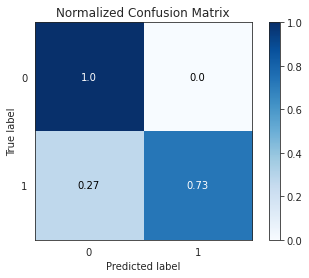

In [127]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_tree, normalize=True);

##### **Relatório de Classificação**

**Analisando o Relatório de classificação:**

*   Recall: 73,17% é  capacidade desse modelo identificar todas as operações ilícitas;
*   AUC: 0.8657.

In [128]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_tree, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_tree)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_tree)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9995    0.9997    0.9996     71079
           1     0.8333    0.7317    0.7792       123

    accuracy                         0.9993     71202
   macro avg     0.9164    0.8657    0.8894     71202
weighted avg     0.9992    0.9993    0.9993     71202

Acurácia: 0.9993

AUC: 0.8657



##### **Visualização da Árvore de Decisão**

É possível também visualizar como ficou a nossa árvore, criando um dot e desenhando ele usando as bibliotecas abaixo.

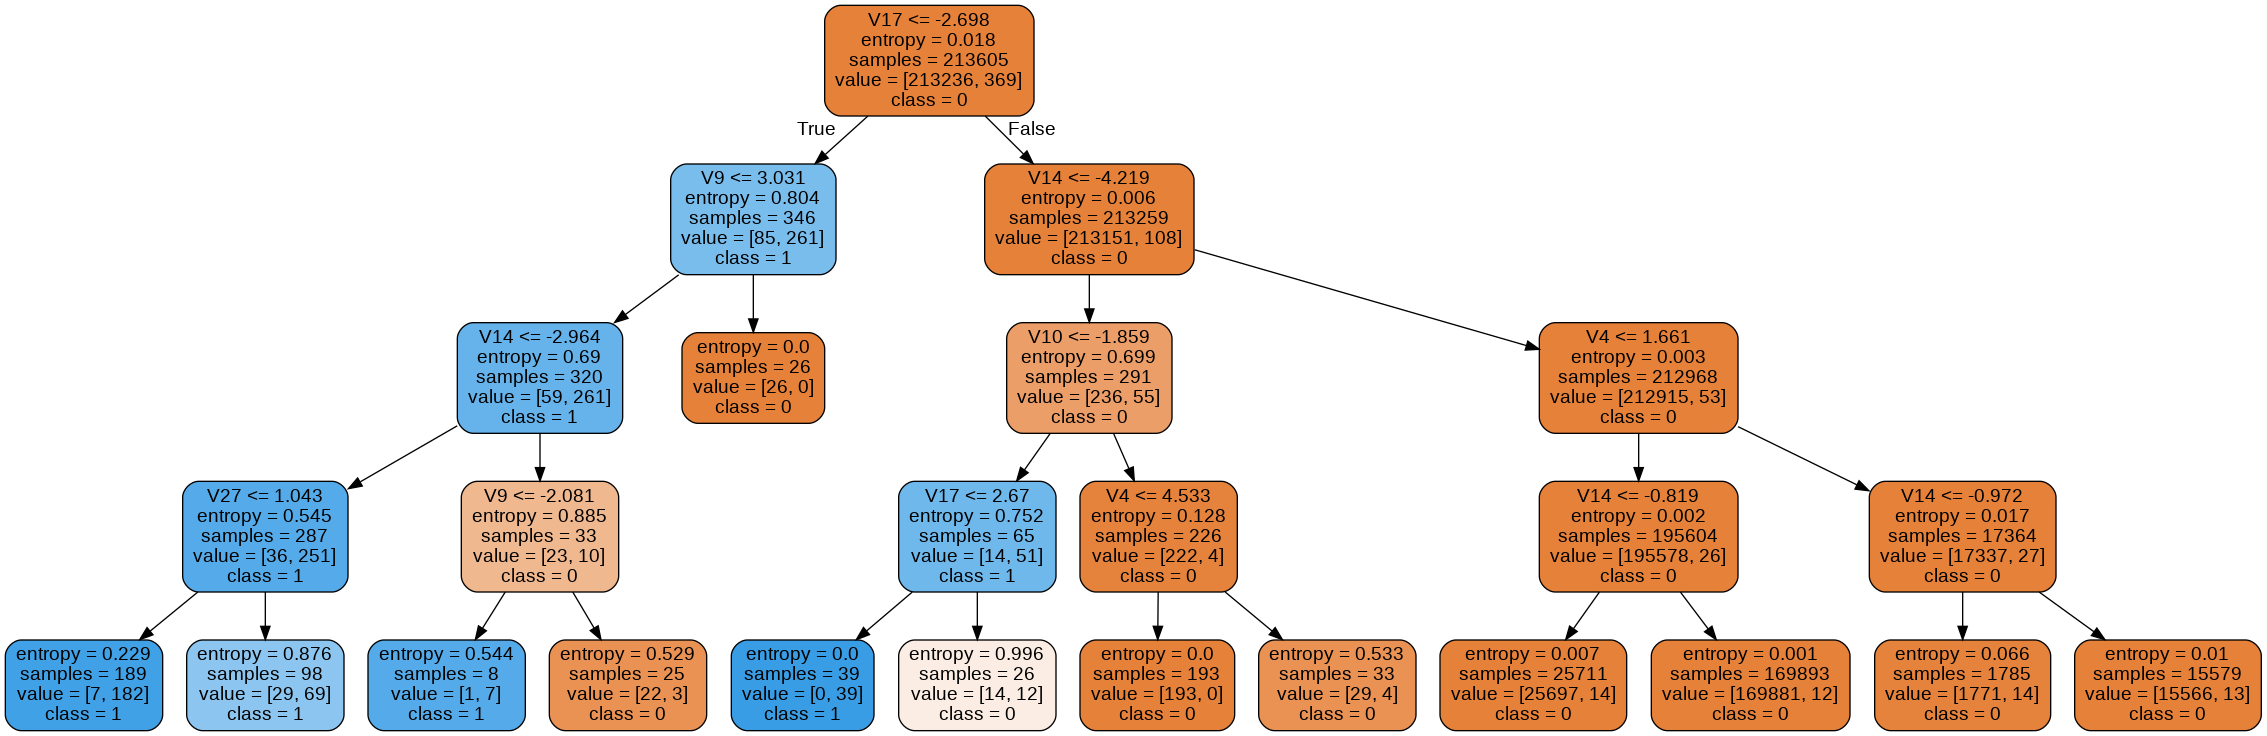

In [129]:
# importar bibliotecas
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# criar DOT 
dot = export_graphviz(model_tree, filled=True, rounded=True,
                      feature_names=X.columns, class_names=['0', '1'])

# plotar
graph = pydotplus.graph_from_dot_data(dot)  
Image(graph.create_png())

### **Árvore de decisão com os dados balanceados pelo método Under-sampling**

Considerando o modelo `DecisionTreeClassifier` (a partir do `sklearn.tree`), vamos instanciar um modelo e treiná-lo nesses dados balanceados.

In [130]:
# Instanciar e escolher os hyperparameters
model_tree_rus = DecisionTreeClassifier(max_depth=4, criterion="entropy")

# Fit do modelo (treinar)
model_tree_rus.fit(X_rus, y_rus)

# Fazer previsões em cima de novos dados
y_pred_tree_rus = model_tree_rus.predict(X_test)

#### **Avaliar o desempenho do modelo**

##### **Matriz de confusão**

Obtemos os seguintes resultados:

* Para as **transações lícitas**:
  * 97% foram classificadas corretamente (verdadeiro negativo);
  * 3% foram classificadas como fraudulentas (falso positivo);
* Para as **transações fraudulentas**:
  * 15% foram classificadas como lícitas (falso negativo);
  * 85% foram classificadas como fraudulentas (verdadeiro positivo);

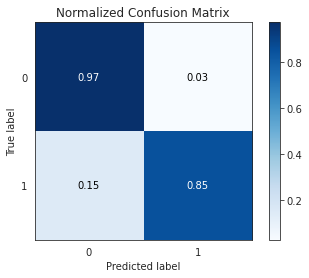

In [131]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_tree_rus, normalize=True);

##### **Relatório de Classificação**

**Analisando o Relatório de classificação:**

*   Recall: 85,37% é  capacidade desse modelo identificar todas as operações ilícitas;
*   AUC: 0.9120.

In [132]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_tree_rus, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_tree_rus)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_tree_rus)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9997    0.9704    0.9848     71079
           1     0.0475    0.8537    0.0899       123

    accuracy                         0.9702     71202
   macro avg     0.5236    0.9120    0.5374     71202
weighted avg     0.9981    0.9702    0.9833     71202

Acurácia: 0.9702

AUC: 0.9120



##### **Visualização da Árvore de Decisão**

É possível também visualizar como ficou a nossa árvore, criando um dot e desenhando ele usando as bibliotecas abaixo.

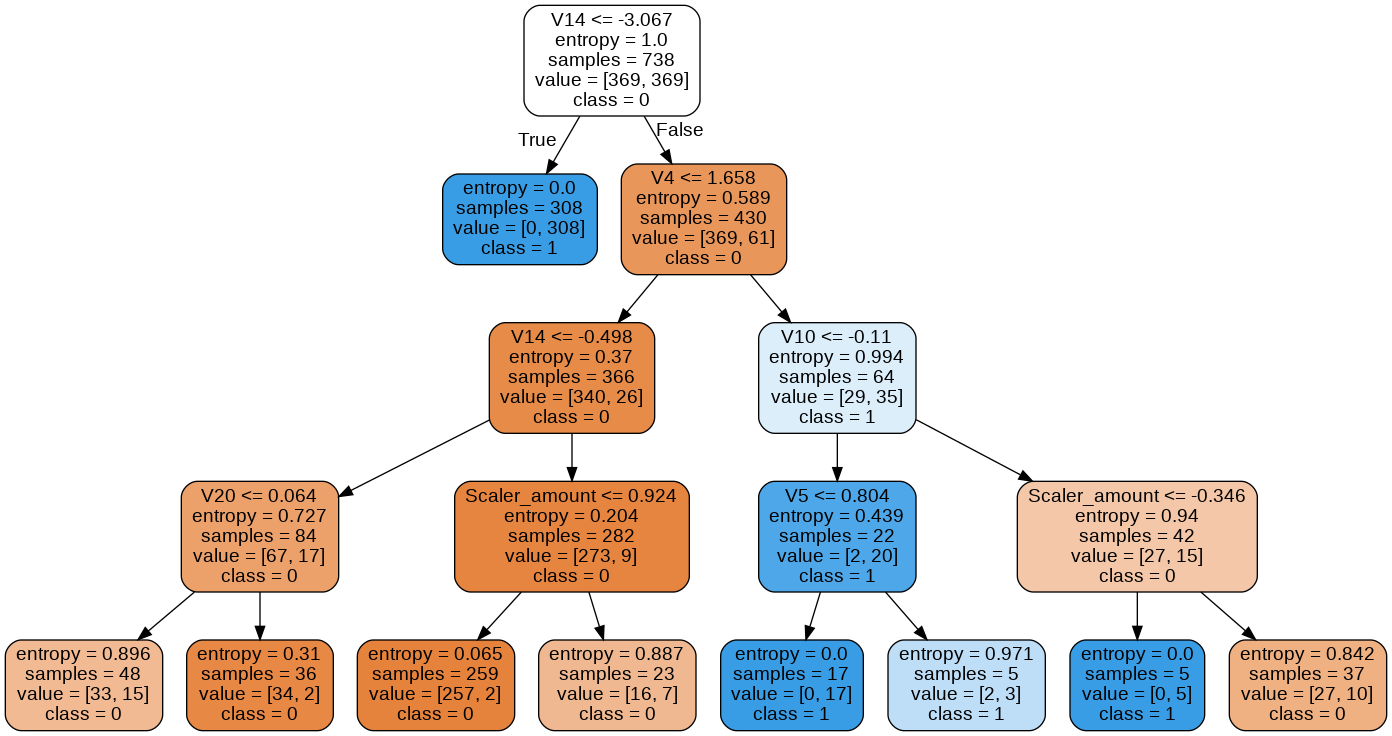

In [133]:
# criar DOT 
dot = export_graphviz(model_tree_rus, filled=True, rounded=True,
                      feature_names=X.columns, class_names=['0', '1'])

# plotar
graph = pydotplus.graph_from_dot_data(dot)  
Image(graph.create_png())

### **Árvore de decisão com os dados balanceados pelo método Over-sampling**

Considerando o modelo `DecisionTreeClassifier` (a partir do `sklearn.tree`), vamos instanciar um modelo e treiná-lo nesses dados balanceados.

In [134]:
# Instanciar e escolher os hyperparameters
model_tree_ros = DecisionTreeClassifier(max_depth=4, criterion="entropy")

# Fit do modelo (treinar)
model_tree_ros.fit(X_ros, y_ros)

# Fazer previsões em cima de novos dados
y_pred_tree_ros = model_tree_ros.predict(X_test)

#### **Avaliar o desempenho do modelo**

##### **Matriz de confusão**

Obtemos os seguintes resultados:

* Para as **transações lícitas**:
  * 99% foram classificadas corretamente (verdadeiro negativo);
  * 1% foram classificadas como fraudulentas (falso positivo);
* Para as **transações fraudulentas**:
  * 17% foram classificadas como lícitas (falso negativo);
  * 83% foram classificadas como fraudulentas (verdadeiro positivo);

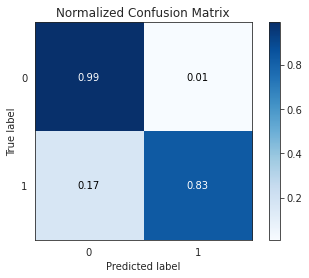

In [135]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_tree_ros, normalize=True);

##### **Relatório de Classificação**

**Analisando o Relatório de classificação:**

*   Recall: 82.93% é  capacidade desse modelo identificar todas as operações ilícitas;
*   AUC: 0.9084.

In [136]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_tree_ros, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_tree_ros)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_tree_ros)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9997    0.9875    0.9936     71079
           1     0.1033    0.8293    0.1838       123

    accuracy                         0.9873     71202
   macro avg     0.5515    0.9084    0.5887     71202
weighted avg     0.9982    0.9873    0.9922     71202

Acurácia: 0.9873

AUC: 0.9084



##### **Visualização da Árvore de Decisão**

É possível também visualizar como ficou a nossa árvore, criando um dot e desenhando ele usando as bibliotecas abaixo.

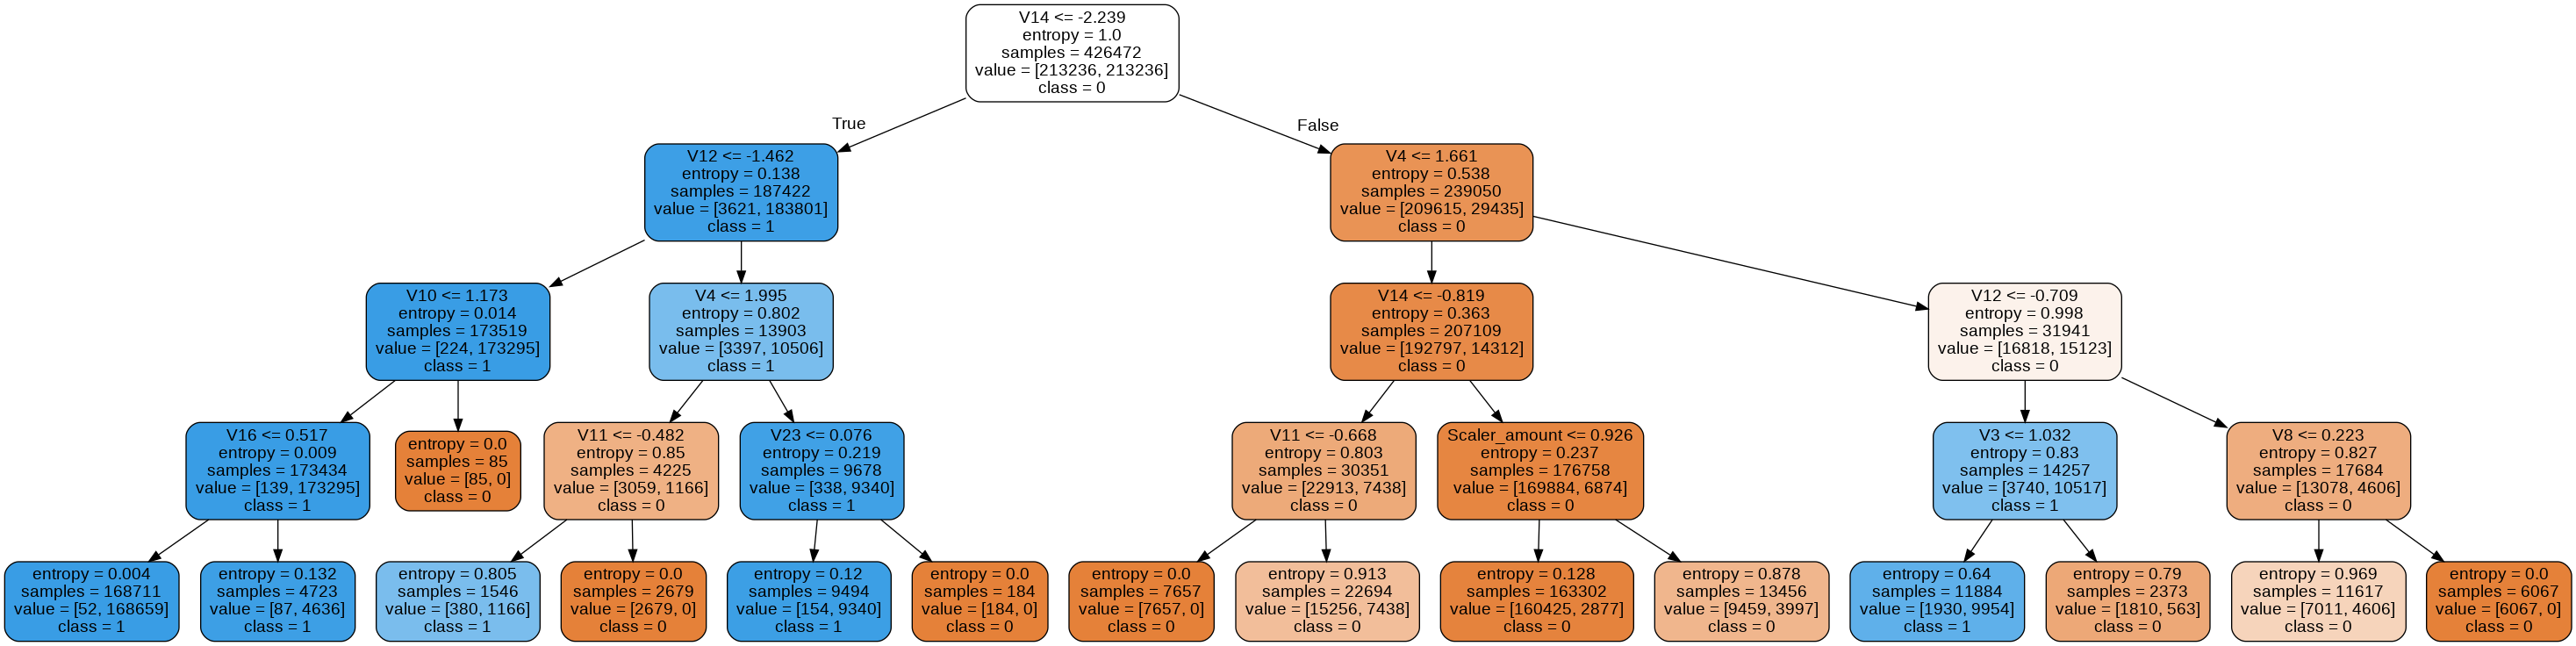

In [137]:
# criar DOT 
dot = export_graphviz(model_tree_ros, filled=True, rounded=True,
                      feature_names=X.columns, class_names=['0', '1'])

# plotar
graph = pydotplus.graph_from_dot_data(dot)  
Image(graph.create_png())

##**Comparando o desempenho dos modelos**

In [138]:
desempenho = {"Precision": [precision_score(y_test,y_pred_log),precision_score(y_test,y_pred_rus),precision_score(y_test,y_pred_ros),precision_score(y_test,y_pred_tree),precision_score(y_test,y_pred_tree_rus),precision_score(y_test,y_pred_tree_ros)],
              "Recall_score": [recall_score(y_test,y_pred_log),recall_score(y_test,y_pred_rus),recall_score(y_test,y_pred_ros),recall_score(y_test,y_pred_tree),recall_score(y_test,y_pred_tree_rus),recall_score(y_test,y_pred_tree_ros)],
              "F1-score": [f1_score(y_test,y_pred_log),f1_score(y_test,y_pred_rus),f1_score(y_test,y_pred_ros),f1_score(y_test,y_pred_tree),f1_score(y_test,y_pred_tree_rus),f1_score(y_test,y_pred_tree_ros)],
              "Accuracy": [accuracy_score(y_test,y_pred_log),accuracy_score(y_test,y_pred_rus),accuracy_score(y_test,y_pred_ros),accuracy_score(y_test,y_pred_tree),accuracy_score(y_test,y_pred_tree_rus),accuracy_score(y_test,y_pred_tree_ros)],
              "Roc_auc_score": [roc_auc_score(y_test,y_pred_log),roc_auc_score(y_test,y_pred_rus),roc_auc_score(y_test,y_pred_ros),roc_auc_score(y_test,y_pred_tree),roc_auc_score(y_test,y_pred_tree_rus),roc_auc_score(y_test,y_pred_tree_ros)]
}

columns_model = "LogisticRegression_desbalanceado,LogisticRegression_under,LogisticRegression_over, DecisionTree_desbalanceado, DecisionTree_under, DecisionTree_over"

df_des = pd.DataFrame(desempenho.values(),index=desempenho.keys(), columns=columns_model.split(','))

df_des

,LogisticRegression_desbalanceado,LogisticRegression_under,LogisticRegression_over,DecisionTree_desbalanceado,DecisionTree_under,DecisionTree_over
Precision,0.875000,0.049416,0.069418,0.833333,0.047468,0.103343
Recall_score,0.626016,0.894309,0.902439,0.731707,0.853659,0.829268
F1-score,0.729858,0.093657,0.128920,0.779221,0.089936,0.183784
Accuracy,0.999199,0.970099,0.978933,0.999284,0.970155,0.987276
Roc_auc_score,0.812931,0.932270,0.940752,0.865727,0.912008,0.908409


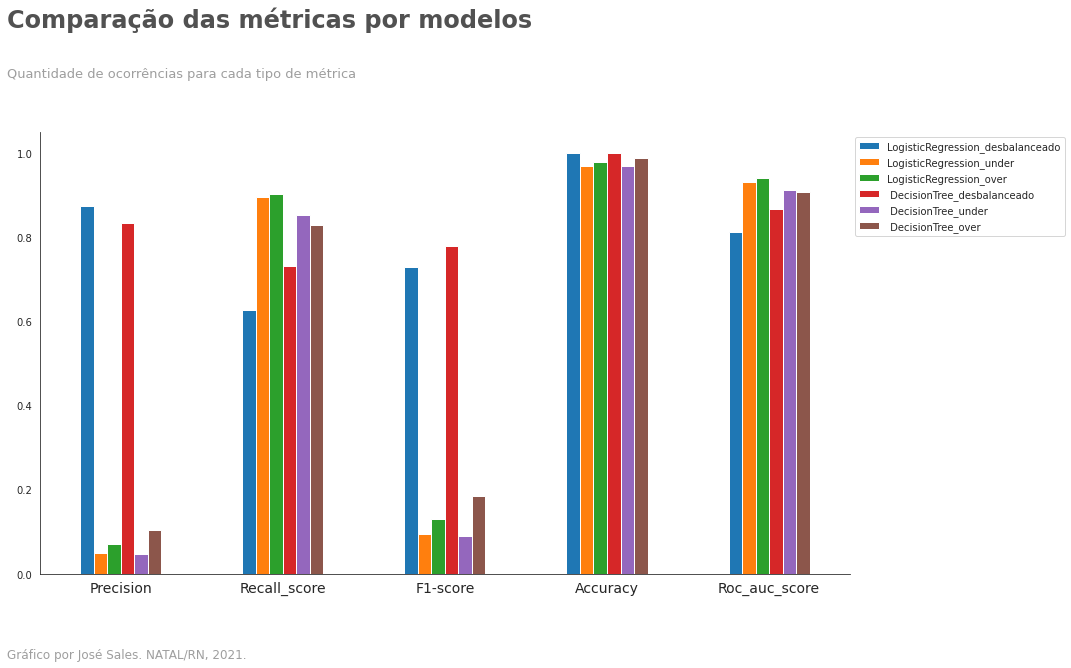

In [145]:
# Plotando o gráfico
fig, ax = plt.subplots(figsize=(15, 10), dpi = 72)
df_des.plot.bar(ax=ax)
ax.legend(bbox_to_anchor=(1, 1))

# title
ax.text(-0.7, 1.3,'Comparação das métricas por modelos', fontsize=24, color=CINZA_TEXTO, fontweight='bold')
ax.text(-0.7, 1.18,'Quantidade de ocorrências para cada tipo de métrica', fontsize=13, color=CINZA)

# remover spines da direita e superior
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# rodapé
ax.text(
    -0.7,
    -0.2,
    "Gráfico por José Sales. NATAL/RN, 2021.",
    fontsize=12, color=CINZA
    )



plt.xticks(rotation=0, fontsize=14)
plt.tight_layout();


## **Conclusão**


De modo a simplificar nossa análise, vamos considerar apenas as métricas recall e AUC para estabelecer qual foi o modelo mais eficiente na detecção de fraudes em cartões de crédito.

Assim, observa-se que os maiores valores de recall e AUC são dos modelos de **Regressão Logística** utilizando o métodos **Over-sampling e Under-Sampling**, respectivamente.
 
Regressão Logística (Over-sampling):
* *Recall*: 0.9024; e
*AUC: 0.9408.

Regressão Logística (Under-sampling):
* *Recall*: 0.8943; e
* AUC: 0.9323.

Por outro lado, lidando com os dados **desbalanceados**, nota-se que o modelo de **Árvore de decisão** obteve melhores resultados.

Árvore de decisão (desbalanceado):
* *Recall*: 0.7317; e
* AUC: 0.8657.

Regressão Logística (desbalanceado):
* *Recall*: 0.6260; e
* AUC: 0.8129

Portanto, após a comparação das métricas de desempenho é possível notar a importância do balanceamento dos dados e escolher o método **Over-sampling** juntamente com o modelo de **Regressão Logística** como o mais eficiente nesse estudo de detecção de fraudes em cartões de crédito.